In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats


all_data = np.load("./all_data.npy", allow_pickle=True)

dates = all_data[:, 0]  # 日期
wind = all_data[:, 1]  # 万德全A
hs300 = all_data[:, 2]  # 沪深300
citic = all_data[:, 3:]  # 中信行情

print('数据开始时间',dates[0])
print('数据结束时间',dates[-1])
print('长度',len(dates))

# 2005-2021年数据 2005-2011年是样本内数据 12-21年是样本外数据

N_beta = 200
# idx 0-200 2008-2012; idx 500-700 2017-2021
idx_start = 253
idx_end = 800

data = np.hstack((wind.reshape(-1,1)/100.0, citic/100.0))
data = data.astype(float)

# beta
beta_mat = np.zeros((data.shape[0] - N_beta, data.shape[1] - 1))
for i in range(beta_mat.shape[0]):
    # beta = np.array(np.cov(data[i:i+N_beta, :].T)[0,:])
    beta = np.diag(np.cov(data[i:i+N_beta, :].T))
    beta = beta[1:] / beta[0]
    beta_mat[i, :] = beta

# spearman
ret_mat = data[N_beta-1:, :]
spearman = []
for i in range(beta_mat.shape[0]):
    spearman.append(stats.spearmanr(ret_mat[i+1, 1:] / ret_mat[i, 1:] - 1, beta_mat[i, :])[0])

# 从 N_beta 开始可以购买
dates = dates[N_beta:]
hs300 = hs300[N_beta:]
wind = wind[N_beta:]

# 分样本内和样本外,start end 之间
dates = dates[idx_start:idx_end]
hs300 = hs300[idx_start:idx_end]
wind = wind[idx_start:idx_end]
spearman = spearman[idx_start:idx_end]

print('回测开始时间',dates[0])
print('回测结束时间',dates[-1])
print('长度',len(dates))

数据开始时间 2005-01-14 00:00:00
数据结束时间 2021-10-29 00:00:00
长度 856
回测开始时间 2014-01-03 00:00:00
回测结束时间 2021-10-29 00:00:00
长度 403


In [2]:
from utils import forward_chunduo
from utils import forward_duokong

In [6]:
cur_res = forward_chunduo(hs300, spearman, threshold=0.177)
print('纯多')
print('收益率', cur_res['Rp'])
print('年华波动',  cur_res['flow'])
print('夏普比率', cur_res['sharp'])
print()

cur_res = forward_duokong(hs300, spearman, threshold=0.177)
print('多空')
print('收益率', cur_res['Rp'])
print('年华波动',  cur_res['flow'])
print('夏普比率', cur_res['sharp'])
print()

print('hs300本身')
Rp = (hs300[-1] / hs300[0]) ** (1 / (len(spearman)/52)) - 1
k = 4
ratio = []
for i in range(len(hs300) // k - 1):
    ratio.append(hs300[i*k+k] / hs300[i*k])
flow = np.std(ratio)*(12**0.5)  # 年化波动率
sharp = Rp / flow  # 夏普比率
print('收益率', Rp)
print('年华波动',  flow)
print('夏普比率', sharp)


纯多
收益率 0.11637732202539319
年华波动 0.15177787498820994
夏普比率 0.7667607814013297

多空
收益率 0.05267218307524124
年华波动 0.24426412103736606
夏普比率 0.2156361845184122

hs300本身
收益率 0.1033372910678736
年华波动 0.22434743166301857
夏普比率 0.4606127661095383


回测开始时间 2015-12-31 00:00:00
回测结束时间 2021-10-29 00:00:00
最大回撤hs300 -0.21037523452157592
最大回撤纯多 -0.10802800000000001
最大回撤多空 -0.10552879550721805


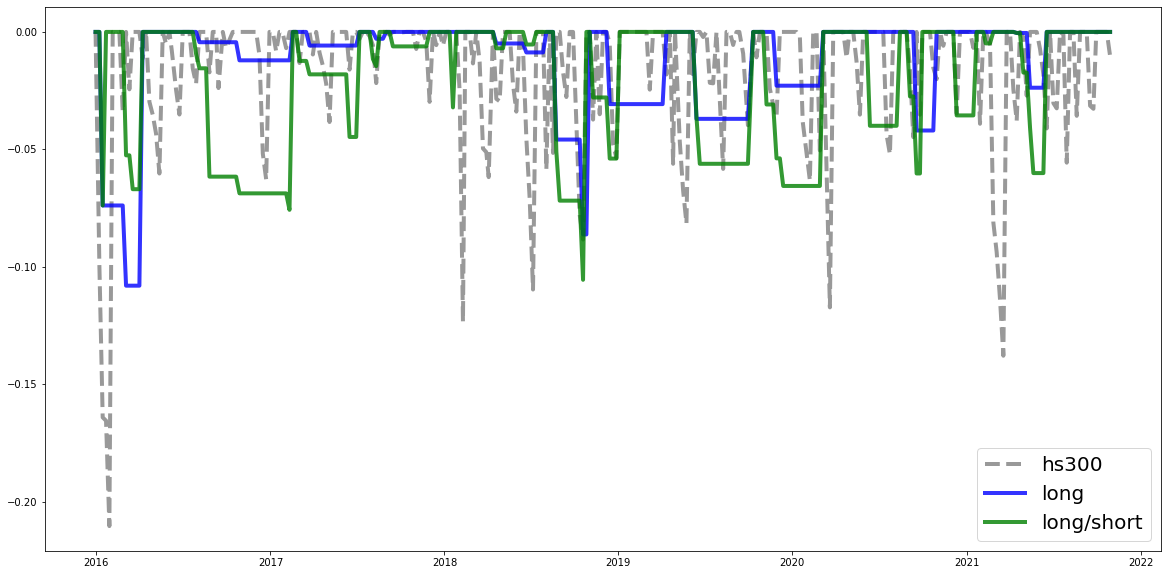

In [19]:
# 研报33 回撤
print('回测开始时间',dates[0])
print('回测结束时间',dates[-1])

back_hs300 = [0]
pre_max = hs300[0]
for i in range(1, len(hs300)):
    if hs300[i] > hs300[i-1]:
        pre_max = hs300[i]
        back_hs300.append(0)
    else:
        back_hs300.append(hs300[i]/pre_max-1)
print('最大回撤hs300', min(back_hs300))

cur_res = forward_chunduo(hs300, spearman, threshold=0.177)
record_money = np.array(cur_res['record_money']) / 1000000
back_chunduo = [0]
pre_max = record_money[0]
for i in range(1, len(record_money)):
    if record_money[i] > record_money[i-1]:
        pre_max = record_money[i]
        back_chunduo.append(0)
    else:
        back_chunduo.append(record_money[i]/pre_max-1)
print('最大回撤纯多', min(back_chunduo))

cur_res = forward_duokong(hs300, spearman, threshold=0.177)
record_money = np.array(cur_res['record_money']) / 1000000
back_duokong = [0]
pre_max = record_money[0]
for i in range(1, len(record_money)):
    if record_money[i] > record_money[i-1]:
        pre_max = record_money[i]
        back_duokong.append(0)
    else:
        back_duokong.append(record_money[i]/pre_max-1)
print('最大回撤多空', min(back_duokong))

plt.figure(figsize=(20,10))
plt.plot(dates, back_hs300, '--', lw=4, label='hs300', c='gray', alpha=0.8)
plt.plot(dates, back_chunduo, lw=4, label='long', c='blue', alpha=0.8)
plt.plot(dates, back_duokong, lw=4, label='long/short', c='green', alpha=0.8)
plt.legend(prop={'size': 20})
plt.savefig('./back_2016_2021.jpg')